In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import glob
import zipfile
import numpy as np
import statsmodels.api as sm
from collections import defaultdict, Counter
import networkx as nx
import pandas as pd


# Browsing Behaviors

In [10]:
import pandas as pd

taobao = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch//BrowsePurchase/1Userbrowsetime.csv',
                     names = ['time', 'user', 'item'])

In [11]:
taobao['hour'] = [int(i) for i in (taobao.time/3600)]
taobao['minute'] = [int(i) for i in (taobao.time/60)]

taobao = taobao.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [21]:
taobao[:3]

,time,user,item,hour,minute
341618,845,1,109,0,14
343061,846,1,109,0,14
347403,851,1,118,0,14


In [22]:
len(taobao)

32373278

In [23]:
taobao5k = taobao[taobao.user <=5000]
len(taobao5k)

324057

In [4]:
# taobao5k.to_csv("/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/taobao5k.txt", 
#                  index = False)

In [10]:
taobao5k[:10]

,time,user,item,hour,minute
341618,845,1,109,0,14
343061,846,1,109,0,14
347403,851,1,118,0,14
348269,852,1,115,0,14
348820,853,1,106,0,14
352991,858,1,108,0,14
354740,860,1,118,0,14
1341979,2207,1,107,0,36
2369665,3554,1,110,0,59
333412,836,3,147,0,13


In [3]:
import pandas as pd

taobao5k = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/taobao5k.txt')
taobao5k[:3]

,time,user,item,hour,minute
0,845,1,109,0,14
1,846,1,109,0,14
2,851,1,118,0,14


In [27]:
taobao1k = taobao5k[taobao5k.user <=1000]
len(taobao1k)

61583

In [26]:
dfg = taobao1k.groupby(['item']).size()
dfg = dfg.sort_values( ascending= 0)
dfg[:10]

item
14358    120
3030      81
3784      78
1377      76
165       66
18583     65
2408      62
590       60
3427      59
1078      58
dtype: int64

In [27]:
dfg_user = taobao1k.groupby(['item'])['user'].nunique().sort_values( ascending= 0)
dfg_user[:10]

item
243     35
1377    31
893     26
579     23
1621    23
2101    22
747     22
590     21
1163    21
874     20
Name: user, dtype: int64

In [29]:
dic_pvuv = defaultdict(list)
for i in dfg.index:
    dic_pvuv[i] = [ dfg[i], dfg_user[i] ]  

## Flow Network

In [9]:
taobao0 = taobao[taobao['hour']==0]
len(taobao0)

2421981

In [7]:
C = np.array(taobao1k[['user', 'item']])
len(C)

61583

In [8]:
from flownetwork import flownetwork as fn

In [9]:
g = fn.constructFlowNetwork(C)

In [10]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 30497\nNumber of edges: 54836\nAverage in degree:   1.7981\nAverage out degree:   1.7981'

In [119]:
h = fn.flowBalancing(g)

In [120]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [121]:
nx.info(h)

'Name: \nType: DiGraph\nNumber of nodes: 426227\nNumber of edges: 1756917\nAverage in degree:   4.1220\nAverage out degree:   4.1220'

In [122]:
edge_df = pd.DataFrame(h.edges(), columns = ['from', 'to'])
a = edge_df[edge_df['from']=='source']
len(a)

94613

In [123]:
a[:3]

,from,to
1334980,source,0
1334981,source,2
1334982,source,4


In [124]:
h['source'][0].values()[0]

3

In [11]:
aici = fn.getAICI(g)
aici.items()[:3]

[(0, [4.0, 62.836904017557814]),
 (1, [1.0, 21.708180543070306]),
 (2, [2.0, 28.729655806512806])]

In [21]:
ac_df = pd.DataFrame(aici.values(), index = aici.keys(),
                    columns = ['ai', 'ci'])

#ac_df.to_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/aici.txt')
ac_df[:3]

,ai,ci
0,4.0,62.836904
1,1.0,21.708181
2,2.0,28.729656


In [22]:
di = fn.networkDissipate(g)

In [23]:
fd = fn.flowDistanceFromSource(g)

In [25]:
di.items()[:3]

[(0, [0, 4, 0]), (1, [0, 2, 0]), (2, [5, 37, 7])]

In [24]:
toSink,totalflow,fromSource = np.array(di.values()).T

In [25]:
bdf=pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/1Userpurchasetime.csv', 
                names = ['time', 'user', 'item'])
dfi = bdf.groupby(['item']).size()
dfi = dfi.sort_values( ascending= 0)
dfi[:10]

item
3664     3598
3259     3015
1377     1941
884      1939
874      1839
2177     1833
97       1791
3423     1788
23138    1663
1235     1477
dtype: int64

In [26]:
bdf[:3]

,time,user,item
0,0,66195,212085
1,0,270918,3040
2,0,403636,34546


In [30]:
bdf = bdf[bdf.user <= 1000  ]
dfi = bdf.groupby(['item']).size()
dfi = dfi.sort_values( ascending= 0)
dfi[:10]

item
3259     9
25904    8
1768     7
18605    7
3664     7
17076    6
1377     6
19544    6
2177     6
26950    5
dtype: int64

In [32]:
dfi[2177]

6

In [57]:
dii = {}
for i in di:
    if i in dic_pvuv:
        try:
            sell = dfi[i]
        except:
            sell = 0
        dii[i]=[di[i][0], di[i][1], di[i][2], fd[i], aici[i][1], dic_pvuv[i][0], dic_pvuv[i][1], sell]

In [40]:
sell1k = []
errors = 0
for i in diif.index:
    try:
        a = dfi[i]
        sell1k.append(a)
    except:
        errors += 1
        sell1k.append(0)
print errors

28480


In [37]:
len(sell1k)

30495

In [44]:
len(diif.sell[diif.sell==0])

10402

In [58]:
diif = pd.DataFrame(dii.values(), index = dii.keys(),
                    columns = ['dissipation','totalflow','fromSource', 'flowdistance', 'ci' , 'pv', 'uv', 'sell'])

diif = diif.sort_values('pv', ascending = False)
diif[:20]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell
14358,6,82,1,16.713977,447.211640,120,1,40
3030,3,19,11,3.338166,119.131295,81,15,241
3784,4,15,5,6.114829,108.547893,78,11,458
1377,9,64,20,7.181508,550.737683,76,31,1941
165,0,31,2,9.374617,323.974018,66,19,720
18583,1,25,1,10.157992,183.707837,65,2,22
2408,4,28,4,7.932782,162.844480,62,11,543
590,8,43,6,6.830182,302.548096,60,21,1099
3427,3,42,5,8.694083,299.255058,59,17,1268
1078,4,16,4,6.402240,103.092166,58,13,412


In [59]:
diif.to_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/diif.txt', 
             index = True)

# Load DATA

In [2]:
diif = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/diif.txt', index_col = 0 )
diif[:10]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell
14358,6,82,1,16.713977,447.211640,120,1,40
3030,3,19,11,3.338166,119.131295,81,15,241
3784,4,15,5,6.114829,108.547893,78,11,458
1377,9,64,20,7.181508,550.737683,76,31,1941
165,0,31,2,9.374617,323.974018,66,19,720
18583,1,25,1,10.157992,183.707837,65,2,22
2408,4,28,4,7.932782,162.844480,62,11,543
590,8,43,6,6.830182,302.548096,60,21,1099
3427,3,42,5,8.694083,299.255058,59,17,1268
1078,4,16,4,6.402240,103.092166,58,13,412


In [47]:
diif['sell1k']=sell1k

In [51]:
diif[:5]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell,loop,pv_log,uv_log,dissipation_log,fromSource_log,ci_log,sell_log,sell1k
14358,0,1,2,3,4,5,6,7,8,9,0.693147,1.945910,0.693147,6.105266,3.713572,0
3030,0,1,2,3,4,5,6,7,8,9,2.772589,1.386294,2.484907,4.788585,5.488938,1
3784,0,1,2,3,4,5,6,7,8,9,2.484907,1.609438,1.791759,4.696362,6.129050,5
1377,0,1,2,3,4,5,6,7,8,9,3.465736,2.302585,3.044522,6.313073,7.571474,6
165,0,1,2,3,4,5,6,7,8,9,2.995732,0.000000,1.098612,5.783745,6.580639,1


In [52]:
diif0 = diif[diif.sell==0]
len(diif0)

0

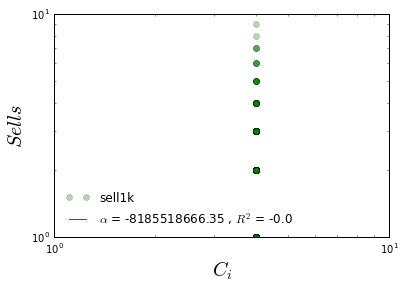

In [49]:
from flownetwork import flownetwork as fn

fn.alloRegressPlot(diif.ci,diif.sell1k,'g','o','$C_i$','$Sells$', loglog=True)


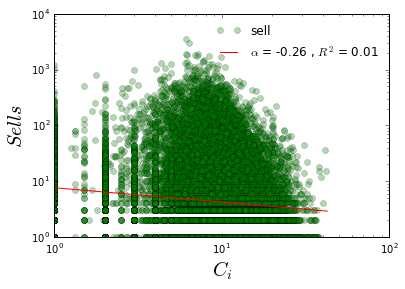

In [18]:
fn.alloRegressPlot(diif.flowdistance,diif.sell,'g','o','$C_i$','$Sells$', loglog=True)


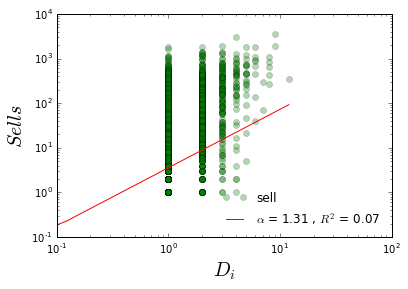

In [20]:
fn.alloRegressPlot(diif.dissipation, diif.sell,'g','o','$D_i$','$Sells$', loglog=True)


In [9]:
len(diif)

30495

In [4]:
diif['loop'] = diif['pv'] - diif['totalflow']

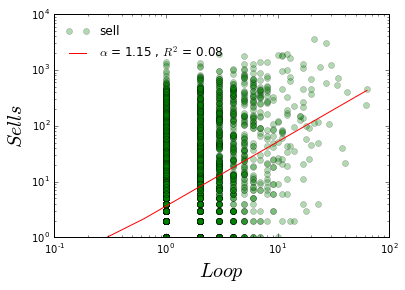

In [67]:
fn.alloRegressPlot(diif.loop,diif.sell,'g','o','$Loop$','$Sells$', loglog=True)


In [5]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)
diif['sell_log'] = np.log(diif.sell+1)


lm = smf.ols(formula='sell_log ~ pv_log + uv_log + fromSource_log + dissipation_log + ci_log + flowdistance',\
             data=diif).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:               sell_log   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     2765.
Date:                Sun, 23 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:26:52   Log-Likelihood:                -49312.
No. Observations:               30495   AIC:                         9.864e+04
Df Residuals:                   30488   BIC:                         9.870e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.5734      0.026    -

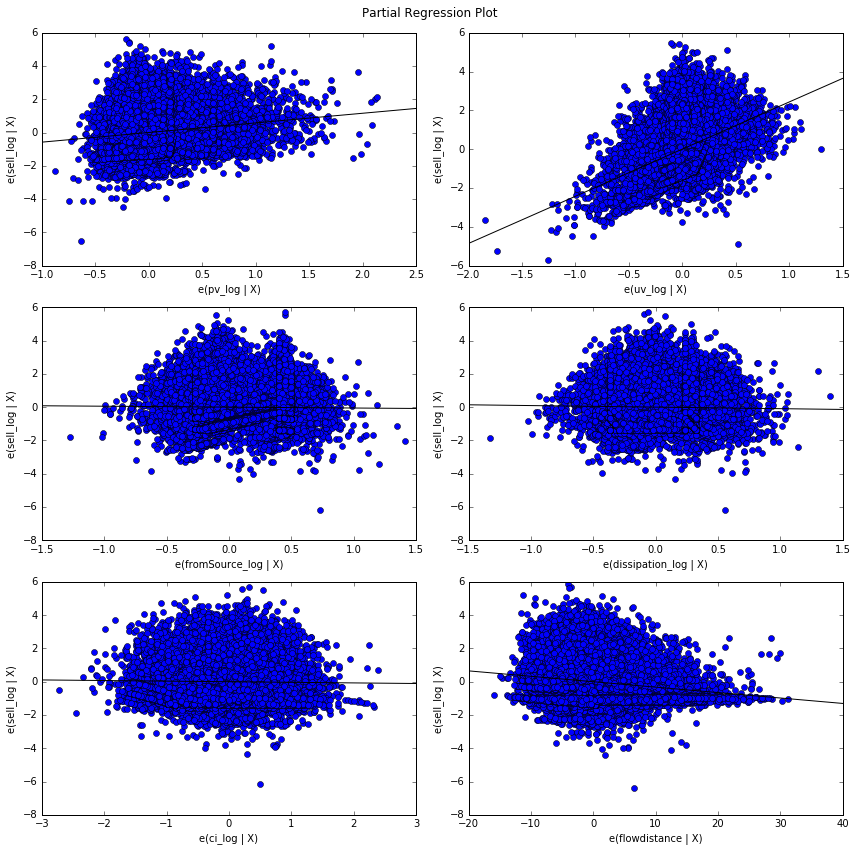

In [6]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,7))
plt.show()

In [7]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)


lm = smf.ols(formula='sell_log ~ dissipation_log + fromSource_log + ci_log + flowdistance', data=diif).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:               sell_log   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     2228.
Date:                Sun, 23 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:27:36   Log-Likelihood:                -52026.
No. Observations:               30495   AIC:                         1.041e+05
Df Residuals:                   30490   BIC:                         1.041e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.2640      0.025     

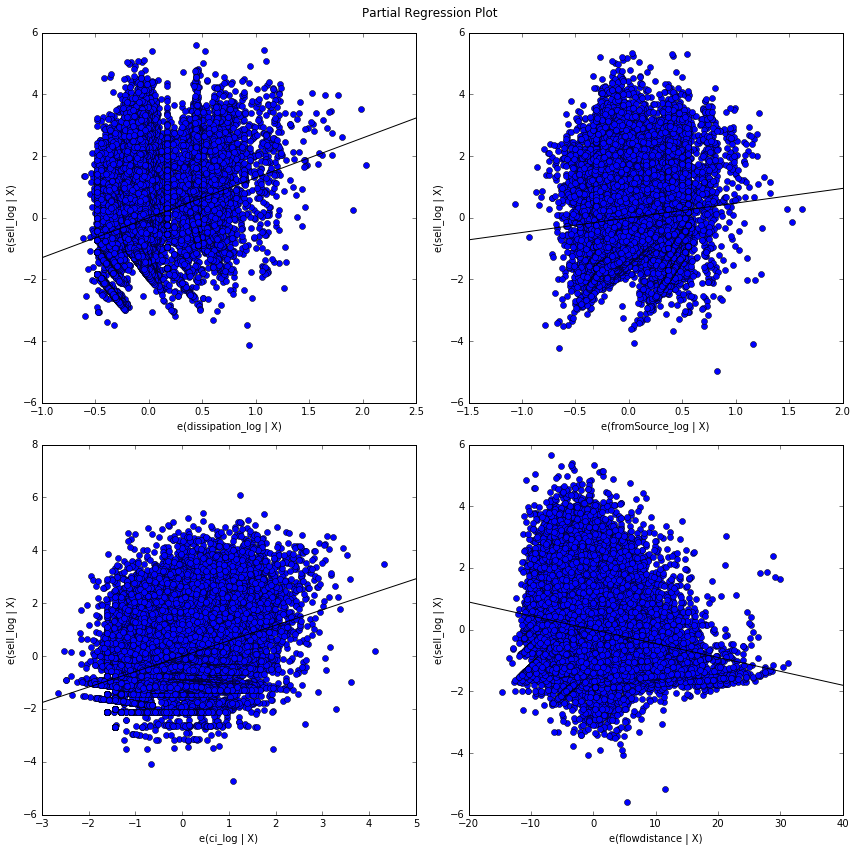

In [8]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,5))
plt.show()

In [39]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)


lm = smf.ols(formula='pv_log ~ dissipation_log + fromSource_log + ci_log + flowdistance', data=diif).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                 pv_log   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Mon, 05 Jun 2017   Prob (F-statistic):               0.00
Time:                        22:45:16   Log-Likelihood:                -5326.3
No. Observations:               30495   AIC:                         1.066e+04
Df Residuals:                   30490   BIC:                         1.070e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.0597      0.005     

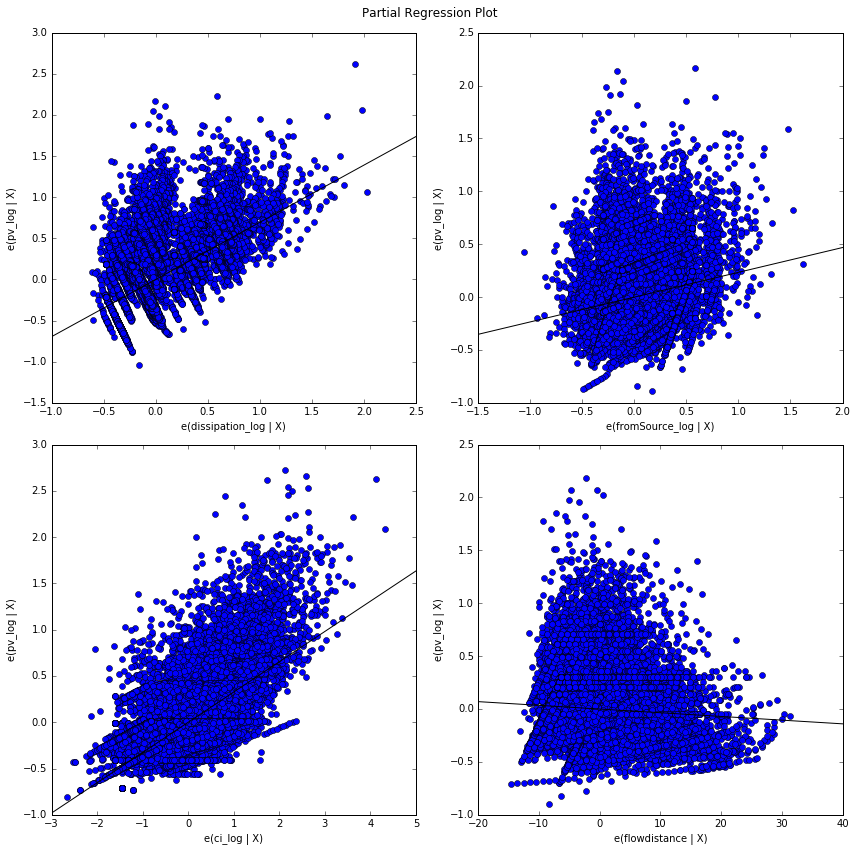

In [40]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,5))
plt.show()

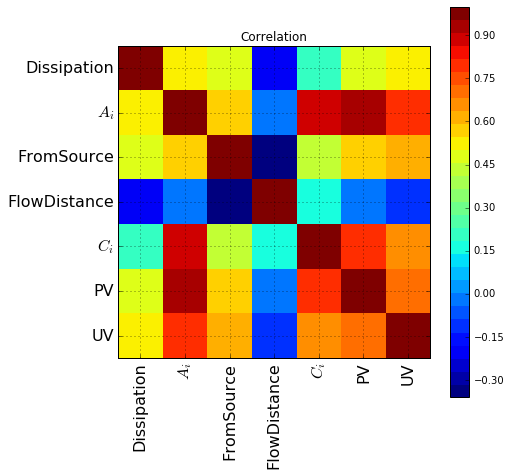

In [33]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(7, 7),facecolor='white')
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation')
    labels=['Dissipation','Dissipation','$A_i$','FromSource','FlowDistance','$C_i$','PV','UV',]
    ax1.set_xticklabels(labels,fontsize=16, rotation = 90)
    ax1.set_yticklabels(labels,fontsize=16)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()

correlation_matrix(diif)

In [25]:
toflow = totalflow-toSink

In [133]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()


## Dissipation Law

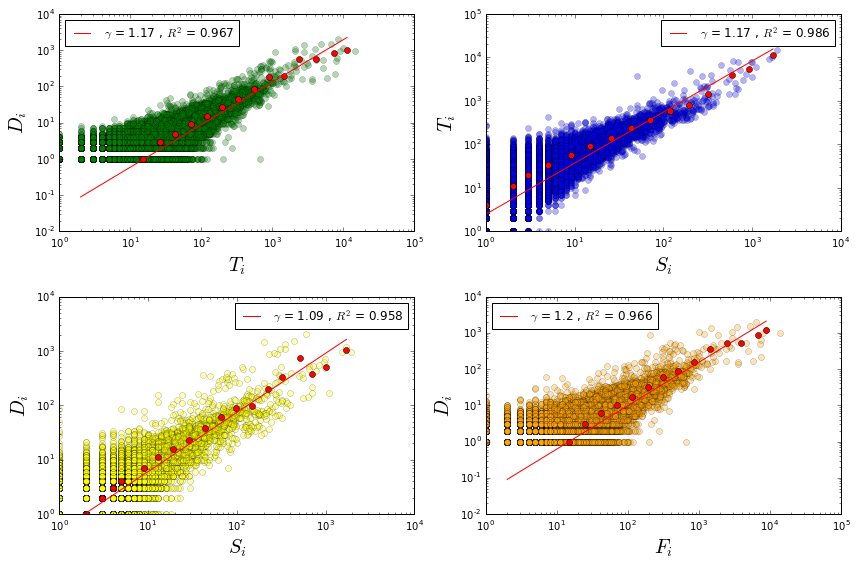

In [144]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$T_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$T_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()


## Allowmetric Growth

In [147]:
taobao_groupby = taobao.groupby('minute')
uv = taobao_groupby['user'].nunique()
pv = taobao_groupby['item'].count()

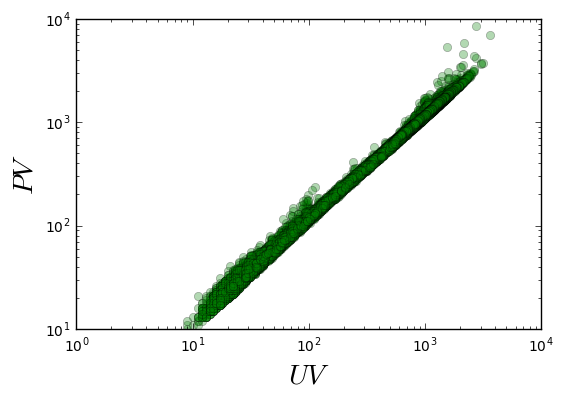

In [125]:
plt.plot(uv, pv, 'go', alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$UV$', fontsize = 20)
plt.ylabel('$PV$', fontsize = 20)

plt.show()

In [153]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, \
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.legend(loc = 0)
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-')

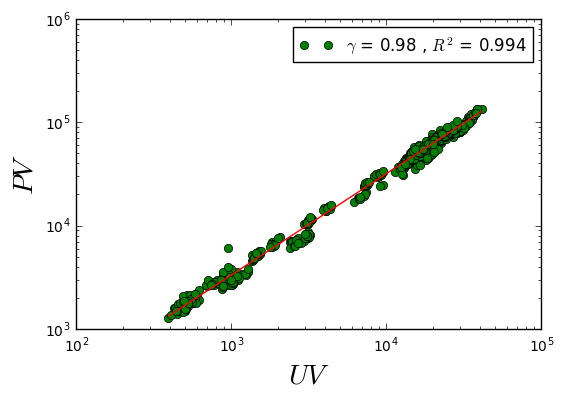

In [149]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

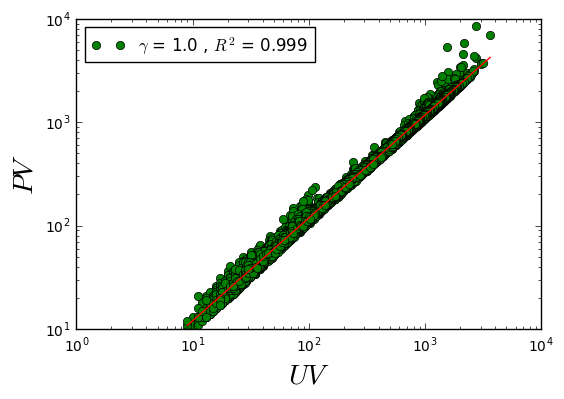

In [140]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

# Purchasing Behaviors

In [47]:
bdf=pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/1Userpurchasetime.csv', 
                names = ['time', 'user', 'item'])

In [48]:
bdf[:3]

,time,user,item
0,0,66195,212085
1,0,270918,3040
2,0,403636,34546


In [49]:
dfi = bdf.groupby(['item']).size()
dfi = dfi.sort_values( ascending= 0)
dfi[:10]

item
3664     3598
3259     3015
1377     1941
884      1939
874      1839
2177     1833
97       1791
3423     1788
23138    1663
1235     1477
dtype: int64

In [52]:
dfi[3664]

3598

In [147]:
bdf['hour'] = [int(i) for i in (bdf.time/3600)]
bdf['minute'] = [int(i) for i in (bdf.time/60)]

bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1])

In [148]:
len(bdf)

1465172

In [149]:
bdf = bdf.sort_values(by = ['hour','user', 'time'], ascending=[1, 1, 1]) 

In [151]:
bdf[:20]

,time,user,item,hour,minute
14852,847,1,109,0,14
68425,2322,6,314,0,38
68426,2322,6,367,0,38
68427,2322,6,302,0,38
13369,814,26,1052,0,13
13370,814,26,1032,0,13
13371,814,26,1045,0,13
13372,814,26,1028,0,13
84032,2659,37,1313,0,44
7926,679,38,1377,0,11


In [152]:
bdf_groupby = bdf.groupby('minute')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

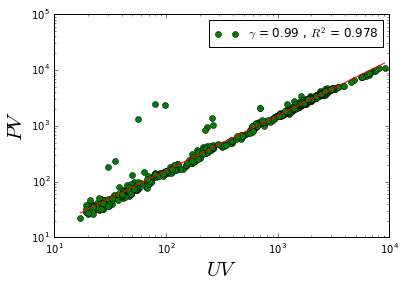

In [154]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

In [155]:
bdf_groupby = bdf.groupby('hour')
uv = bdf_groupby['user'].nunique()
pv = bdf_groupby['item'].count()

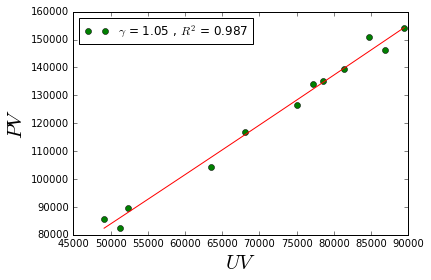

In [157]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', False)

# Machine Learning

In [3]:
diif = pd.read_csv('/Users/chengjun/百度云同步盘/Writing/TaobaoResearch/BrowsePurchase/diif.txt', index_col = 0 )
diif[:10]

,dissipation,totalflow,fromSource,flowdistance,ci,pv,uv,sell
14358,6,82,1,16.713977,447.211640,120,1,40
3030,3,19,11,3.338166,119.131295,81,15,241
3784,4,15,5,6.114829,108.547893,78,11,458
1377,9,64,20,7.181508,550.737683,76,31,1941
165,0,31,2,9.374617,323.974018,66,19,720
18583,1,25,1,10.157992,183.707837,65,2,22
2408,4,28,4,7.932782,162.844480,62,11,543
590,8,43,6,6.830182,302.548096,60,21,1099
3427,3,42,5,8.694083,299.255058,59,17,1268
1078,4,16,4,6.402240,103.092166,58,13,412


In [40]:
diif['pv_log'] = np.log(diif.pv+1)
diif['uv_log'] = np.log(diif.uv+1)

diif['dissipation_log'] = np.log(diif.dissipation+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['totalflow_log'] = np.log(diif.totalflow+1)

diif['ci_log'] = np.log(diif.ci+1)
diif['sell_log'] = np.log(diif.sell+1)

y = diif['sell_log'].values
X = diif[['dissipation_log', 'totalflow_log','fromSource_log', 'flowdistance', 'ci_log', 'pv_log', 'uv_log']].values

 ## Gradient Boosting Regression

In [49]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale


In [51]:
X_scale = scale(X)
y_scale = scale(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X_scale, y_scale, test_size=0.40, random_state=1)

In [52]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


MSE: 0.6449


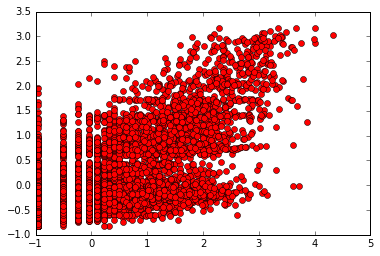

In [53]:
plt.plot(y_test, clf.predict(X_test), 'ro')
plt.show()

In [54]:
print'Variance score: %.2f' % clf.score(X_train, y_train)
print'Variance score: %.2f' % clf.score(X_test, y_test)

Variance score: 0.39
Variance score: 0.36


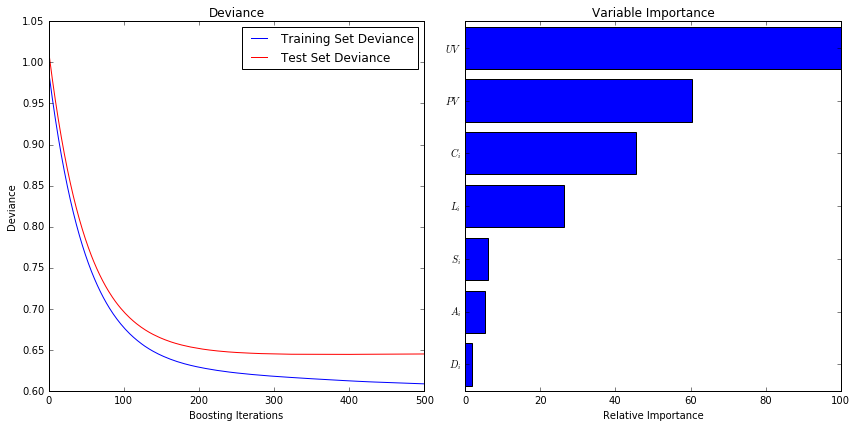

In [55]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.subplot(1, 2, 2)
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
X_feature_names = ['$D_i$', '$A_i$','$S_i$', '$L_i$', '$C_i$', '$PV$', '$UV$']
plt.yticks(pos, X_feature_names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

In [60]:
# This looks like a better option
# source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
r2 = sklearn.metrics.r2_score(y_test,clf.predict(X_test))
print 'R Square =', r2

R Square = 0.364263040114


In [68]:
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X_scale , y_scale, cv = 15)
scores.mean()  

0.11528317296133223

## SVR & Kernal Ridge 

In [69]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [70]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [77]:
svr_rbf = SVR(kernel = 'rbf')#, C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
r2 = sklearn.metrics.r2_score(y_test,svr_rbf.predict(X_test))
print 'R Square =', r2
print'Variance score: %.2f' % svr_rbf.score(X_train, y_train)
print'Variance score: %.2f' % svr_rbf.score(X_test, y_test)

R Square = 0.32839156468
Variance score: 0.35
Variance score: 0.33


In [79]:
kr = KernelRidge(kernel='rbf')
kr.fit(X_train, y_train)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

In [80]:
r2 = sklearn.metrics.r2_score(y_test,kr.predict(X_test))
print 'R Square =', r2
print'Variance score: %.2f' % kr.score(X_train, y_train)
print'Variance score: %.2f' % kr.score(X_test, y_test)

R Square = 0.363021758974
Variance score: 0.38
Variance score: 0.36


# DeepWalk

https://github.com/phanein/deepwalk

    cd deepwalk
    pip install -r requirements.txt
    python setup.py install

Cython compilation failed  https://github.com/phanein/deepwalk/issues/15

1. For the` deepwalk/main.py` I changed a function call `model.save_word2vec_format` to `model.wv.save_word2vec_format`
2. For` gensim/models/word2vec.py`, I changed `self.wv.syn0[i] = self.seeded_vector(self.wv.index2word[i] + str(self.seed))` to `self.wv.syn0[i] = self.seeded_vector(str(self.wv.index2word[i]) + str(self.seed))`. 

**Example Usage**

$deepwalk --input example_graphs/karate.adjlist --output karate.embeddings.txt

In [14]:
import deepwalk
from deepwalk import walks, graph
from deepwalk.skipgram import Skipgram

In [15]:
help(graph)

Help on module deepwalk.graph in deepwalk:

NAME
    deepwalk.graph - Graph utilities.

FILE
    /Users/chengjun/anaconda/lib/python2.7/site-packages/deepwalk-1.0.1-py2.7.egg/deepwalk/graph.py

CLASSES
    collections.defaultdict(__builtin__.dict)
        Graph
    
    class Graph(collections.defaultdict)
     |  Efficient basic implementation of nx `Graph' â€“ Undirected graphs with self loops
     |  
     |  Method resolution order:
     |      Graph
     |      collections.defaultdict
     |      __builtin__.dict
     |      __builtin__.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self)
     |  
     |  adjacency_iter(self)
     |  
     |  check_self_loops(self)
     |  
     |  degree(self, nodes=None)
     |  
     |  has_edge(self, v1, v2)
     |  
     |  make_consistent(self)
     |  
     |  make_undirected(self)
     |  
     |  nodes(self)
     |  
     |  number_of_edges(self)
     |      Returns the number of nodes in the graph
     |  
     |

In [16]:
dir(graph)

['Graph',
 'Iterable',
 'LOGFORMAT',
 'Pool',
 'ProcessPoolExecutor',
 '__author__',
 '__builtins__',
 '__doc__',
 '__email__',
 '__file__',
 '__name__',
 '__package__',
 'build_deepwalk_corpus',
 'build_deepwalk_corpus_iter',
 'clique',
 'cpu_count',
 'defaultdict',
 'from_adjlist',
 'from_adjlist_unchecked',
 'from_networkx',
 'from_numpy',
 'glob',
 'grouper',
 'issparse',
 'iterkeys',
 'load_adjacencylist',
 'load_edgelist',
 'load_matfile',
 'loadmat',
 'logger',
 'logging',
 'open',
 'parse_adjacencylist',
 'parse_adjacencylist_unchecked',
 'path',
 'permutations',
 'product',
 'random',
 'range',
 'shuffle',
 'sys',
 'time',
 'zip',
 'zip_longest']

In [19]:
help(graph.load_adjacencylist)

Help on function load_adjacencylist in module deepwalk.graph:

load_adjacencylist(file_, undirected=False, chunksize=10000, unchecked=True)



In [6]:
deepwalk.__version__

'1.0.0'

In [7]:
import random
import networkx as nx
from collections import Counter
 
 
class Graph(object):
 
    def __init__(self, nx_G):
        self.G = nx_G
        random.seed()  # random seed
        self.corpus_num = 0
        self.length = 0
        self.walks = []
 
    # deepwalk嵌入--返回由流网络构建的语料库
    def deepwalk2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
 
        walk = [start_node]
 
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = G.neighbors(cur)
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
 
        return walk
 
    # 模拟游走
    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print 'DeepWalk2Vec Walk iteration:'
        for walk_iter in range(num_walks):
            print str(walk_iter+1), '/', str(num_walks)
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.deepwalk2vec_walk(walk_length=walk_length, start_node=node))
        self.walks = walks
        return walks
 
    # 通过corpus估计边权
    def set_weights(self, walks=None):
        g_edges = self.G.edges()
        cnt = Counter(g_edges)
        if not walks:
            walks = self.walks
        for walk in walks:
            forward = zip(walk[:-1], walk[1:])
            walk.reverse()
            backward = zip(walk[:-1], walk[1:])
            cnt.update(forward)
            cnt.update(backward)
        self.add_weights(dict(cnt))
        return dict(cnt)
 
    # 添加边权属性
    def add_weights(self, weight_dict):
        nx.set_edge_attributes(self.G, 'weight', weight_dict)
 
    # 获取边权属性
    def get_weights(self):
        return nx.get_edge_attributes(self.G, 'weight')
 
    # 轮盘赌模型-按概率选择指定区域
    def roulette(self, datas, ps):
        return np.random.choice(datas, p=ps)

In [20]:
2395+5003+360

7758